In [1]:
import torch
import torchvision 
import matplotlib.pyplot as plt 
from torchinfo import summary
from torchvision import transforms 

torch.__version__

'2.4.0'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device: {device}")

Current device: cuda


In [3]:
# get data 
from data_setup import download_data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi", remove_source=True)
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
# setup directory paths for training and testing 
train_dir = image_path / "train"
test_dir = image_path / "test"

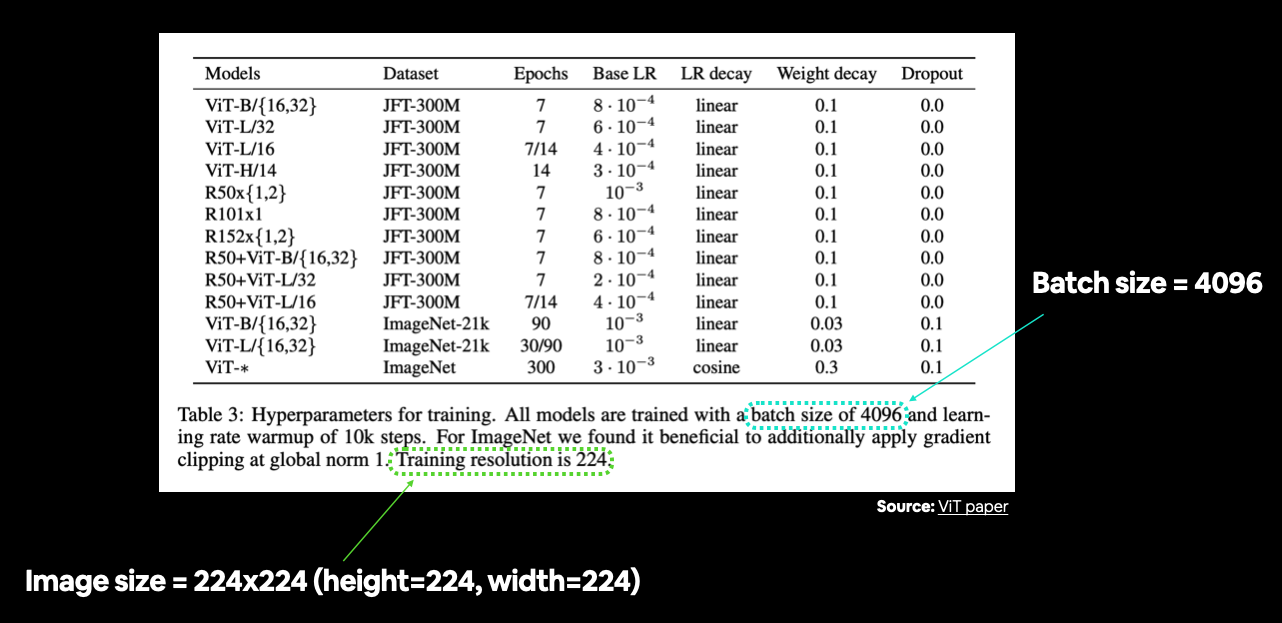

In [5]:
# setup image_size for transform according to table 3
IMAGE_SIZE = 224

manual_transform = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

We're using the pin_memory=True parameter in the create_dataloaders() function to speed up computation. pin_memory=True avoids unnecessary copying of memory between the CPU and GPU memory by "pinning" examples that have been seen before. Though the benefits of this will likely be seen with larger dataset sizes (our FoodVision Mini dataset is quite small).

In [6]:
# setup dataloaders for training and testing with batchsize of 32 (because we're working with small datasets)
from data_setup import create_dataloaders 
BATCH_SIZE = 32 

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir, test_dir=test_dir, train_transform=manual_transform, test_transform=manual_transform, batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1db2d5a8da0>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# take a look at one sample image 
image_batch, label_batch = next(iter(train_dataloader))
img, label = image_batch[0], label_batch[0]

# see the shape of the image 
img.shape

torch.Size([3, 224, 224])

Text(0.5, 1.0, 'pizza')

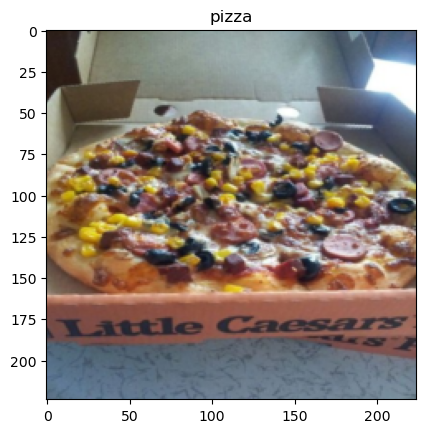

In [8]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label.item()])

## Inputs and Outputs Layer Block

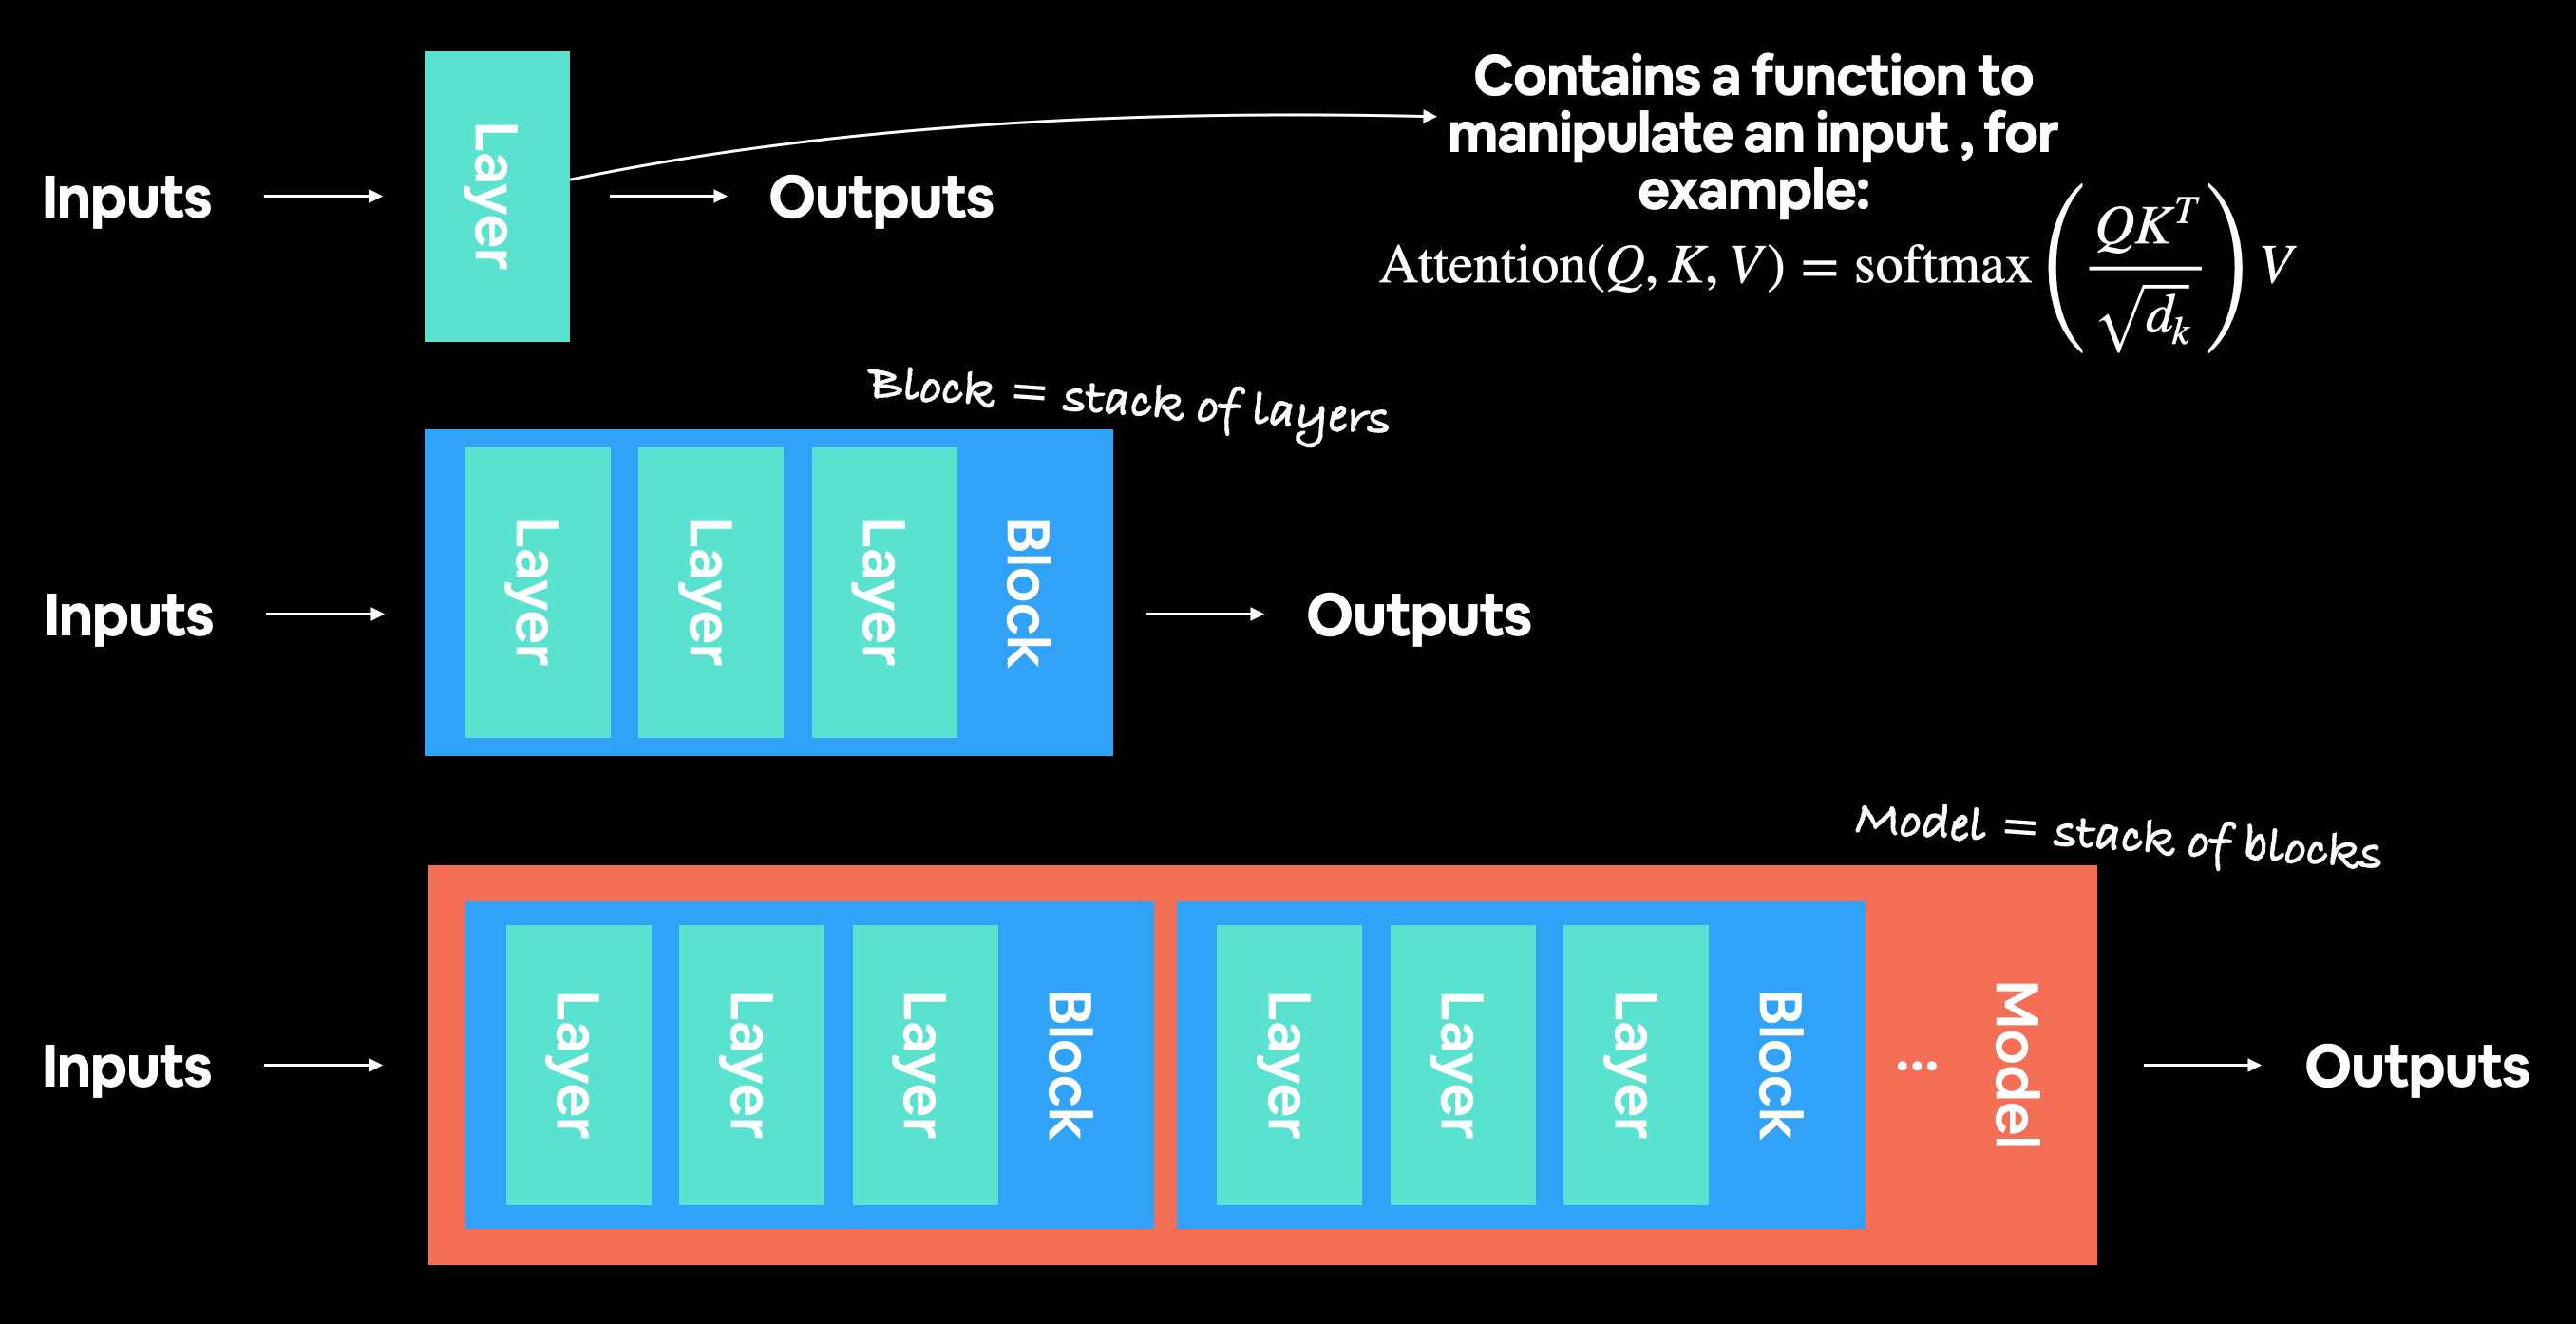

**note:** *A modern deep learning architecture is usually collection of layers and blocks. Where layers take an input (data as a numerical representation) and manipulate it using some kind of function (e.g. the self-attention formula), however this function could be almost anything and then output it. Blocks are generally stacks of layers on top of each other oding a similar thing to a single layer but multiple times.*

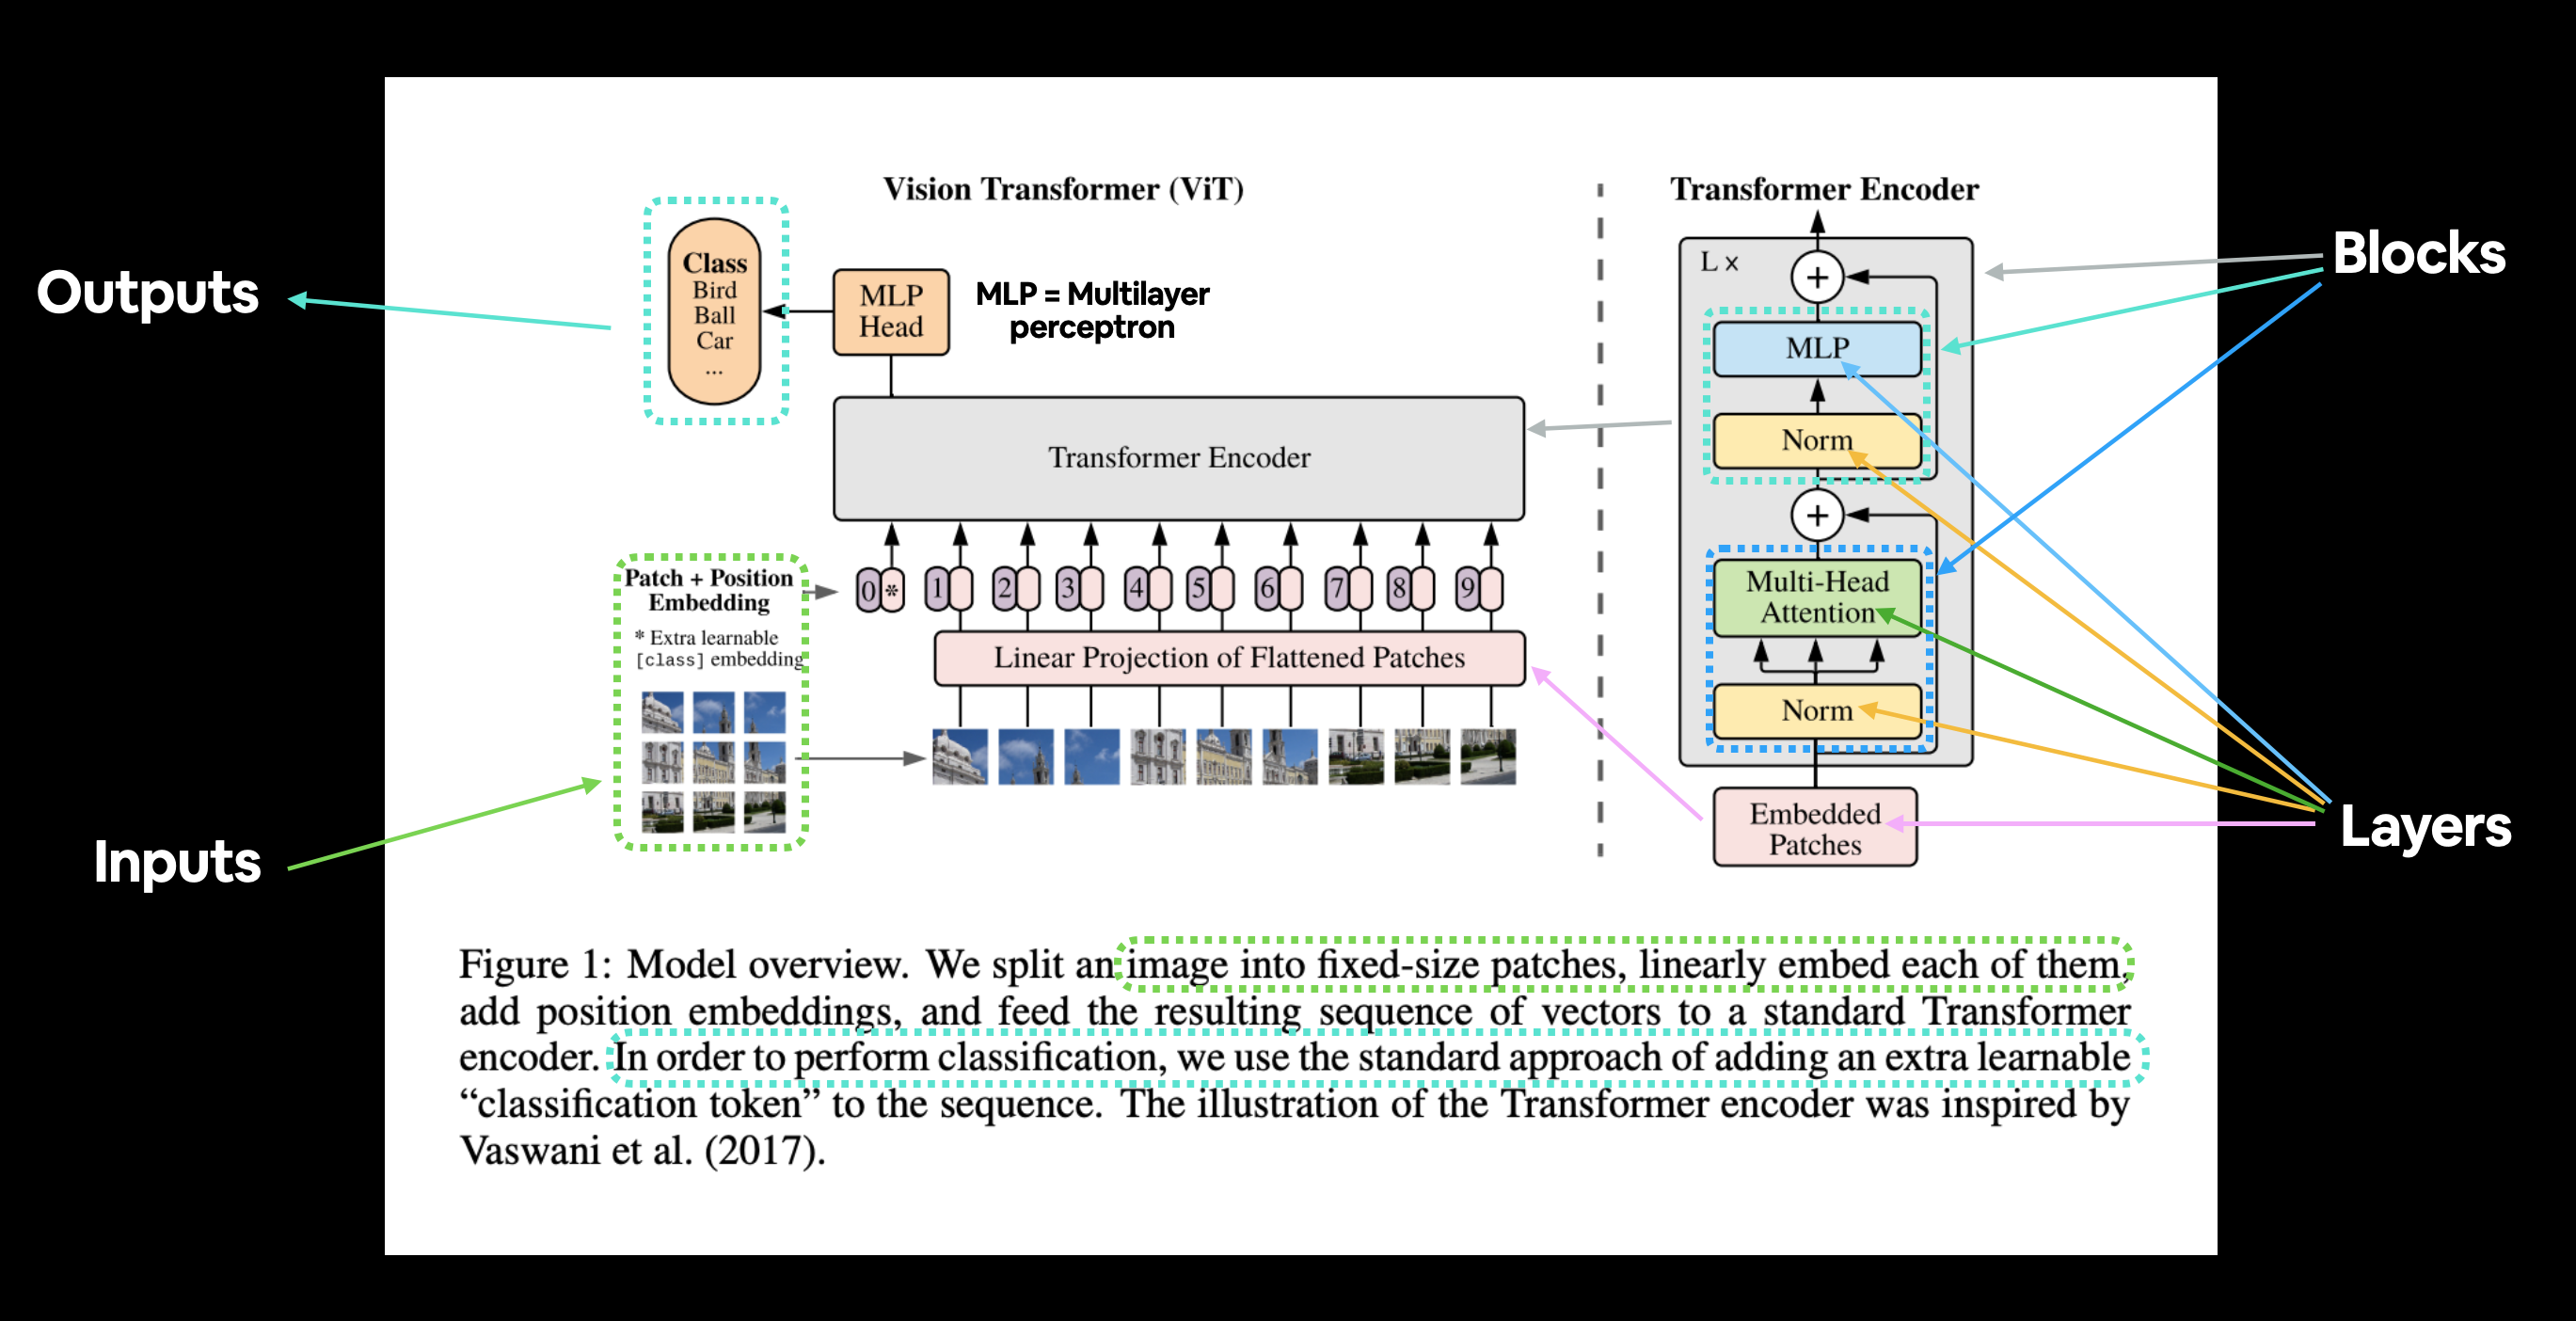

The ViT architecture is comprised of several stages: 
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in. 
* **Linear projection of flattened patches (Embedded patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is  learnable representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention Layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().
* **MLP (Multilayer Perceptron)** - An MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a *forward()* method). In the ViT paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them and a torch.nn.Dropout() layer after each.
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listen above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of  anumber of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the ouput layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the classifier head. The structure of the MLP Head is similar to the MLP block.

## Exploring the Four Equations 

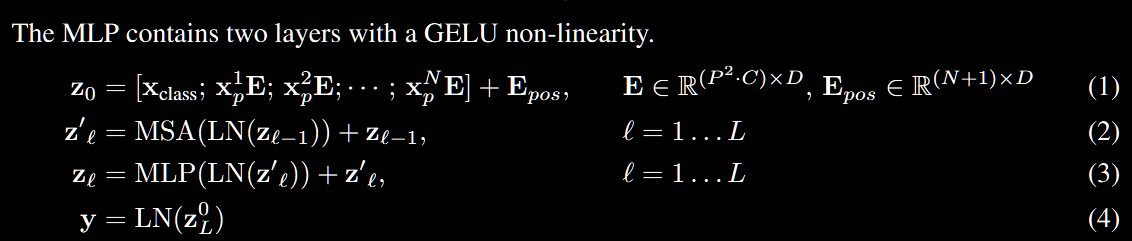

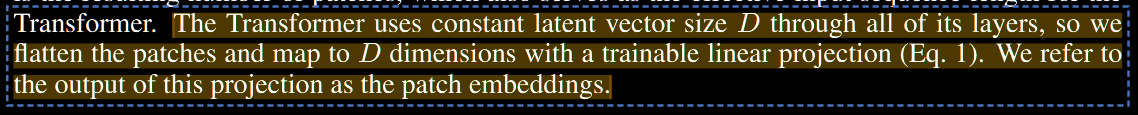
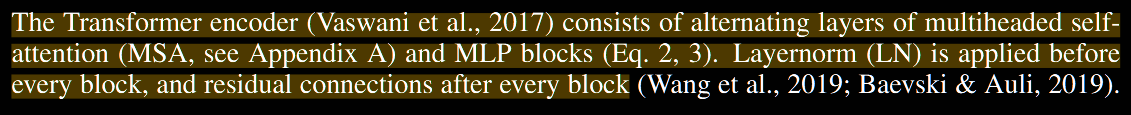
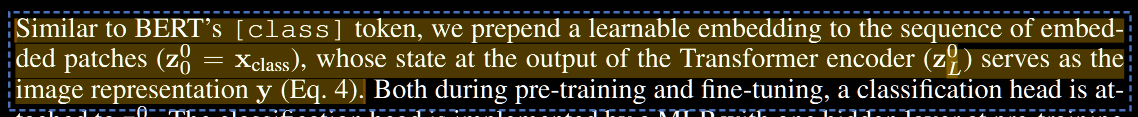

## Map the Equations to the ViT Architecture 

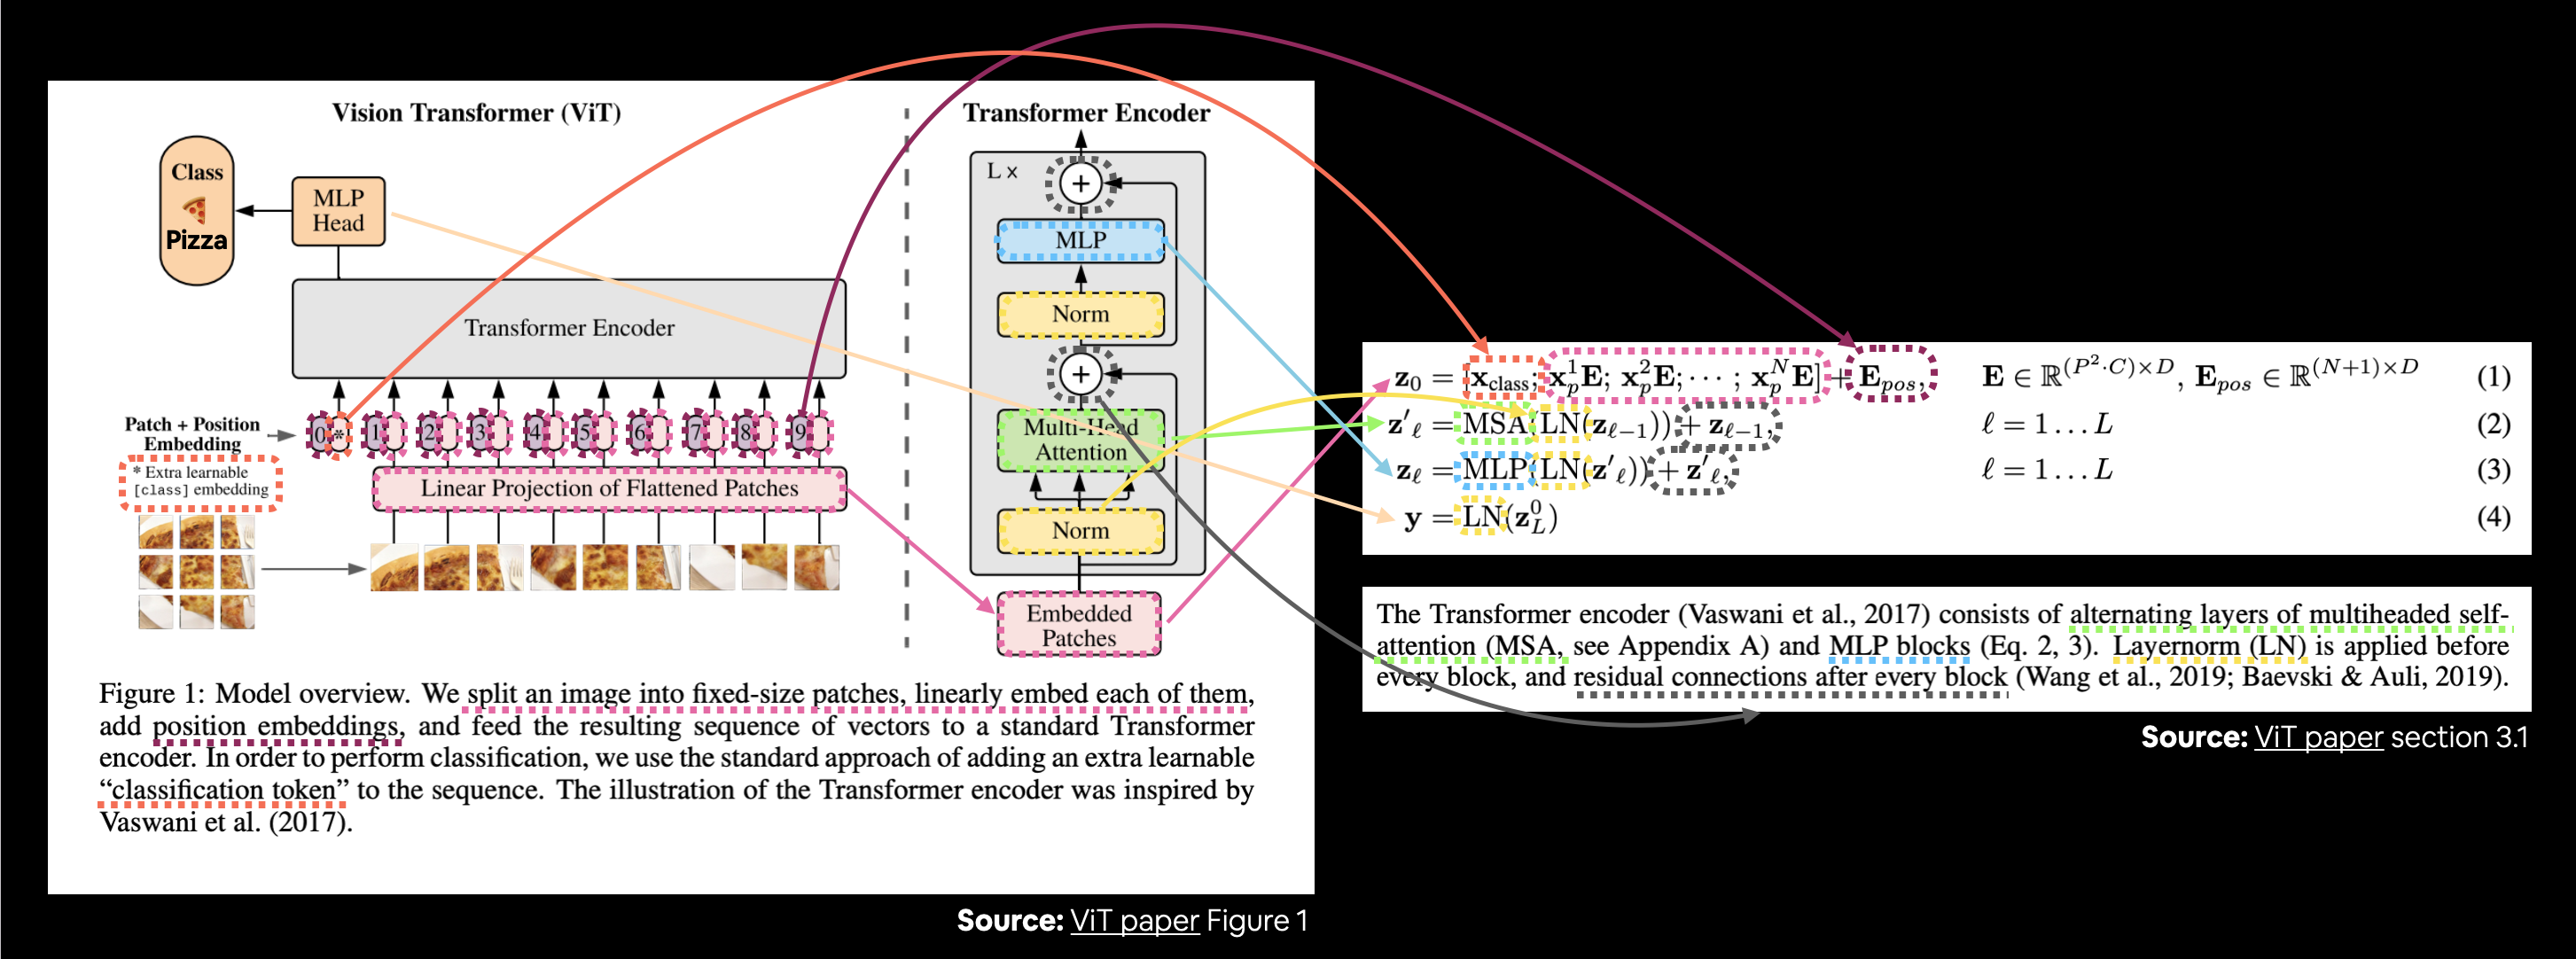

### Equation 1 Overview
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

### Equation 2 Overview
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

### Equation 3 Overview 
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

### Equation 4 Overview 
y = Linear_layer(LN_layer(x_output_MLP_block[0]))

## Replicating the smallest version of the architecture

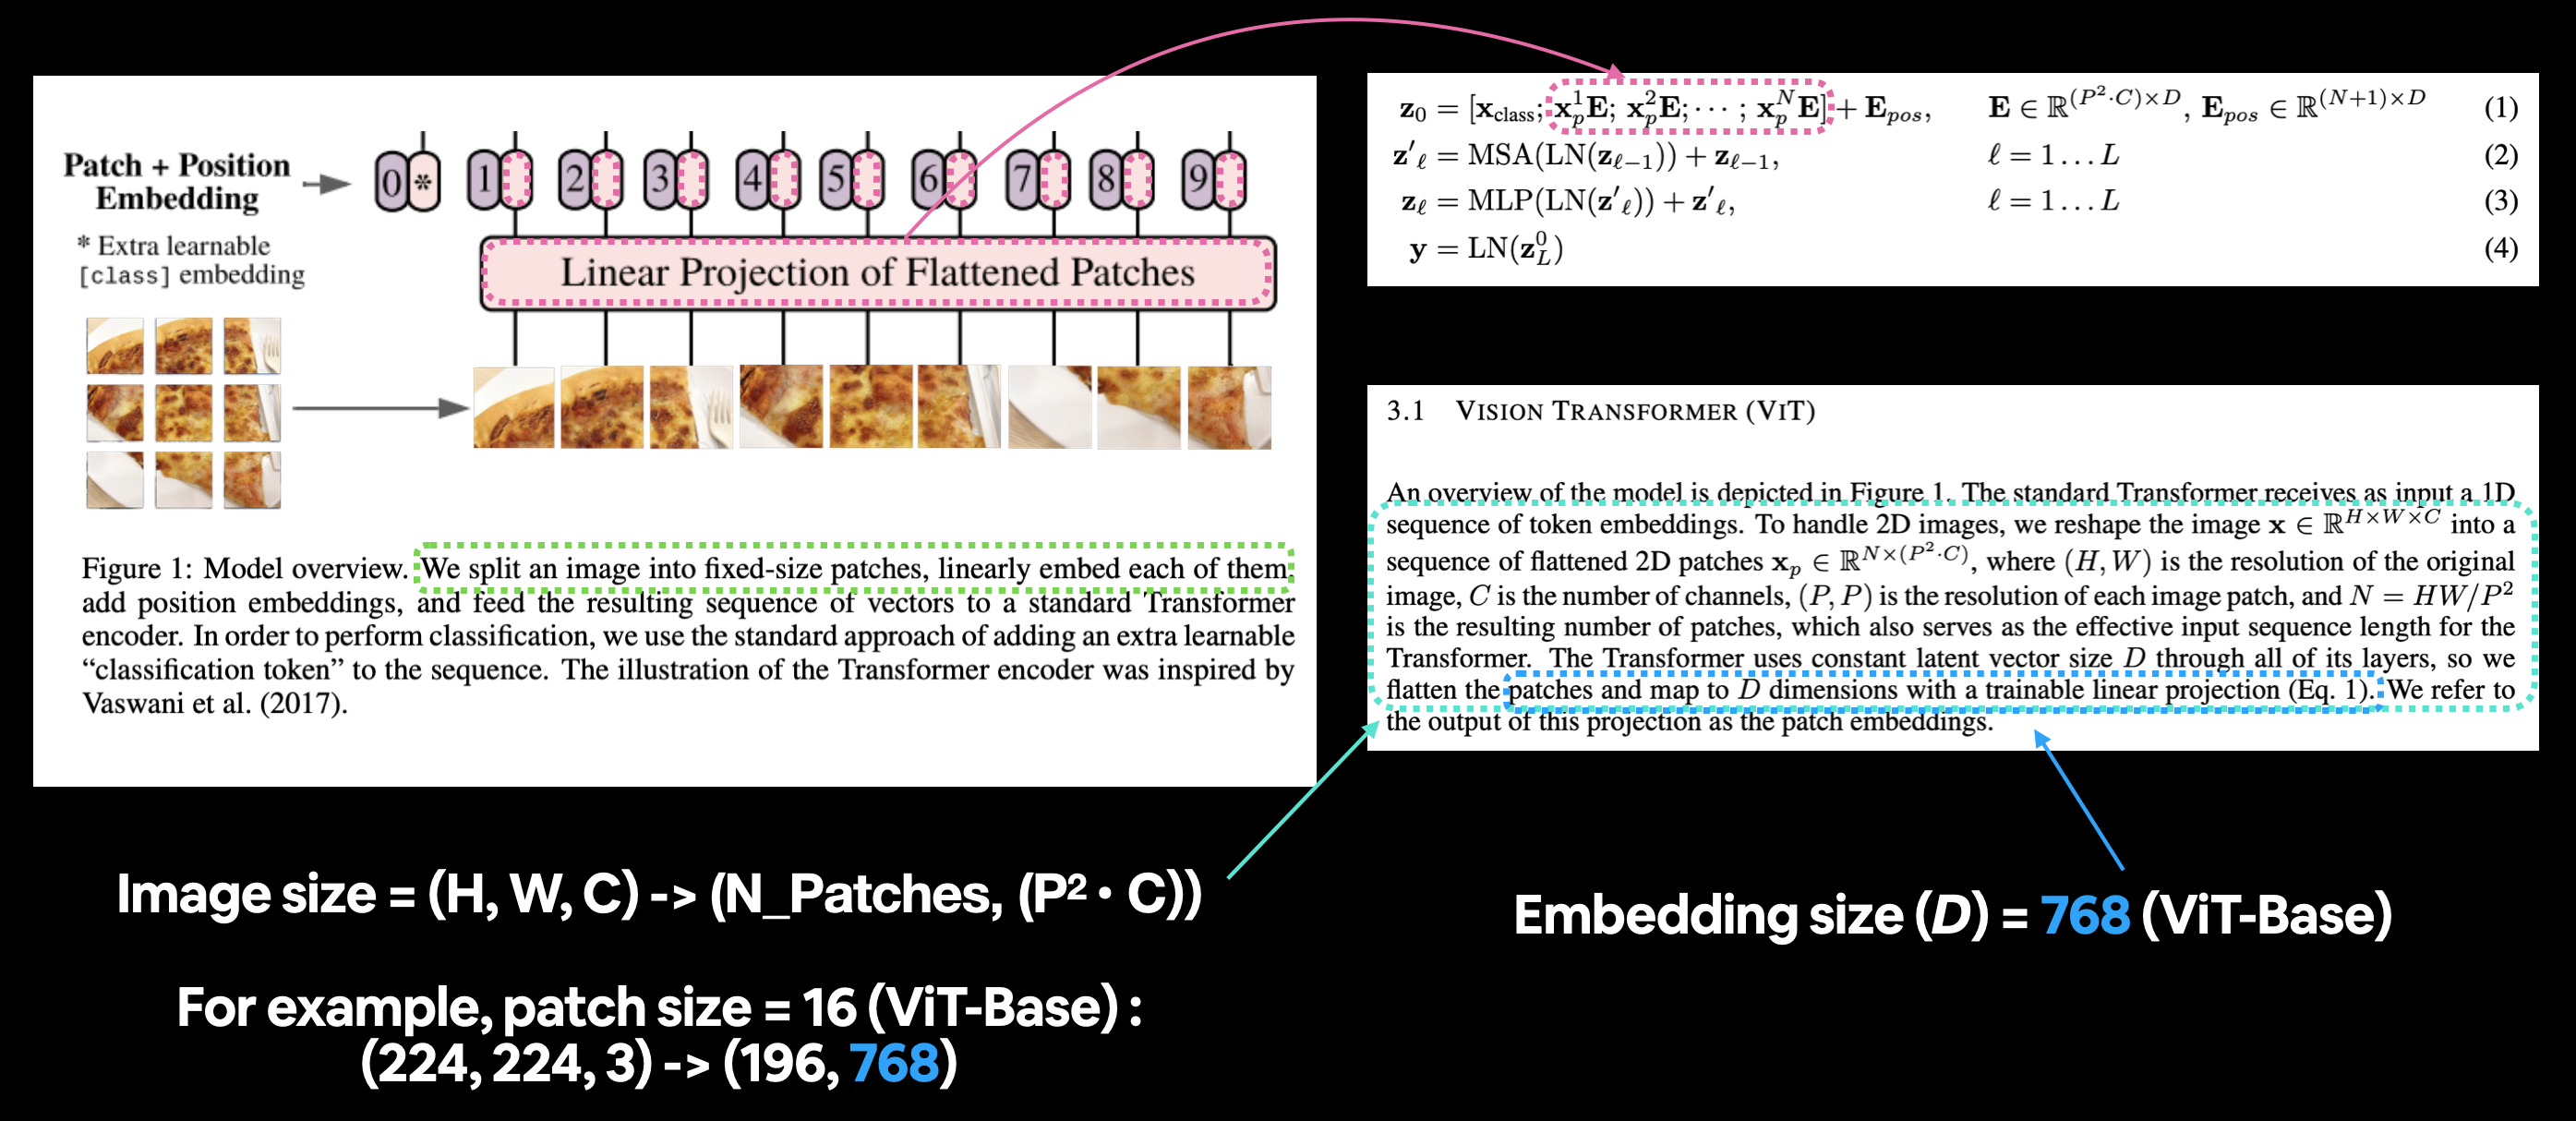

In [12]:
# create examples values
height, width = 224, 224 # H, W the training resolution is 224
color_channels = 3 # C
patch_size = 16 # P

# calculate N (number of patches)
number_of_patches = int((height*width)/patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [13]:
# input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# output shape 
embedding_layer_output_shape = (number_of_patches, patch_size**2, color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 256, 3)


## Turning a single into patches

Text(0.5, 1.0, 'pizza')

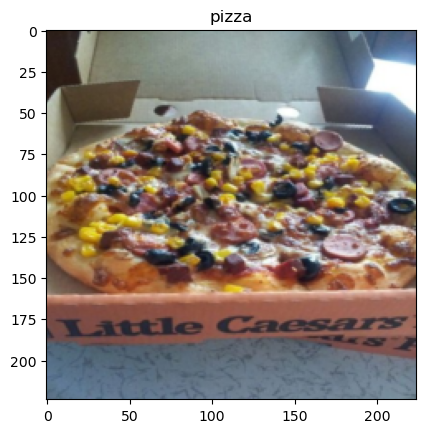

In [16]:
# view a single image
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])

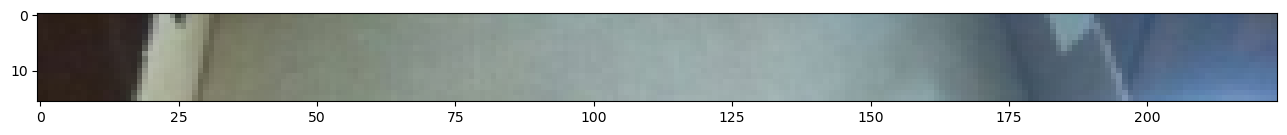

In [23]:
# try to visualize only the top row of patches pixels
image_permuted = img.permute(1, 2, 0)

# index to plot the top row of patches pixels 
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]) # crop the image height only from 0 to patch_size

Number of patches per row: 14.0
Patch size: 16 x 16 pixels


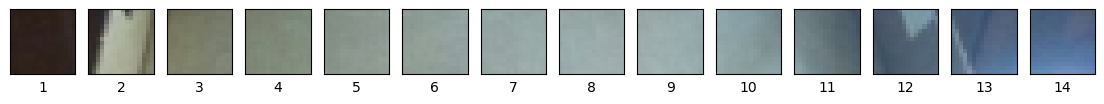

In [26]:
# setup hyperparameters and make sure img_size and patch_size are compatible 
img_size = 224
patch_size = 16
number_of_patches = img_size/patch_size 
assert img_size % patch_size == 0
print(f"Number of patches per row: {number_of_patches}\nPatch size: {patch_size} x {patch_size} pixels")

# create a series of subplots 
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size//patch_size, 
                        figsize=(number_of_patches, number_of_patches), 
                        sharex=True, 
                        sharey=True)

# iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


<function matplotlib.pyplot.show(close=None, block=None)>

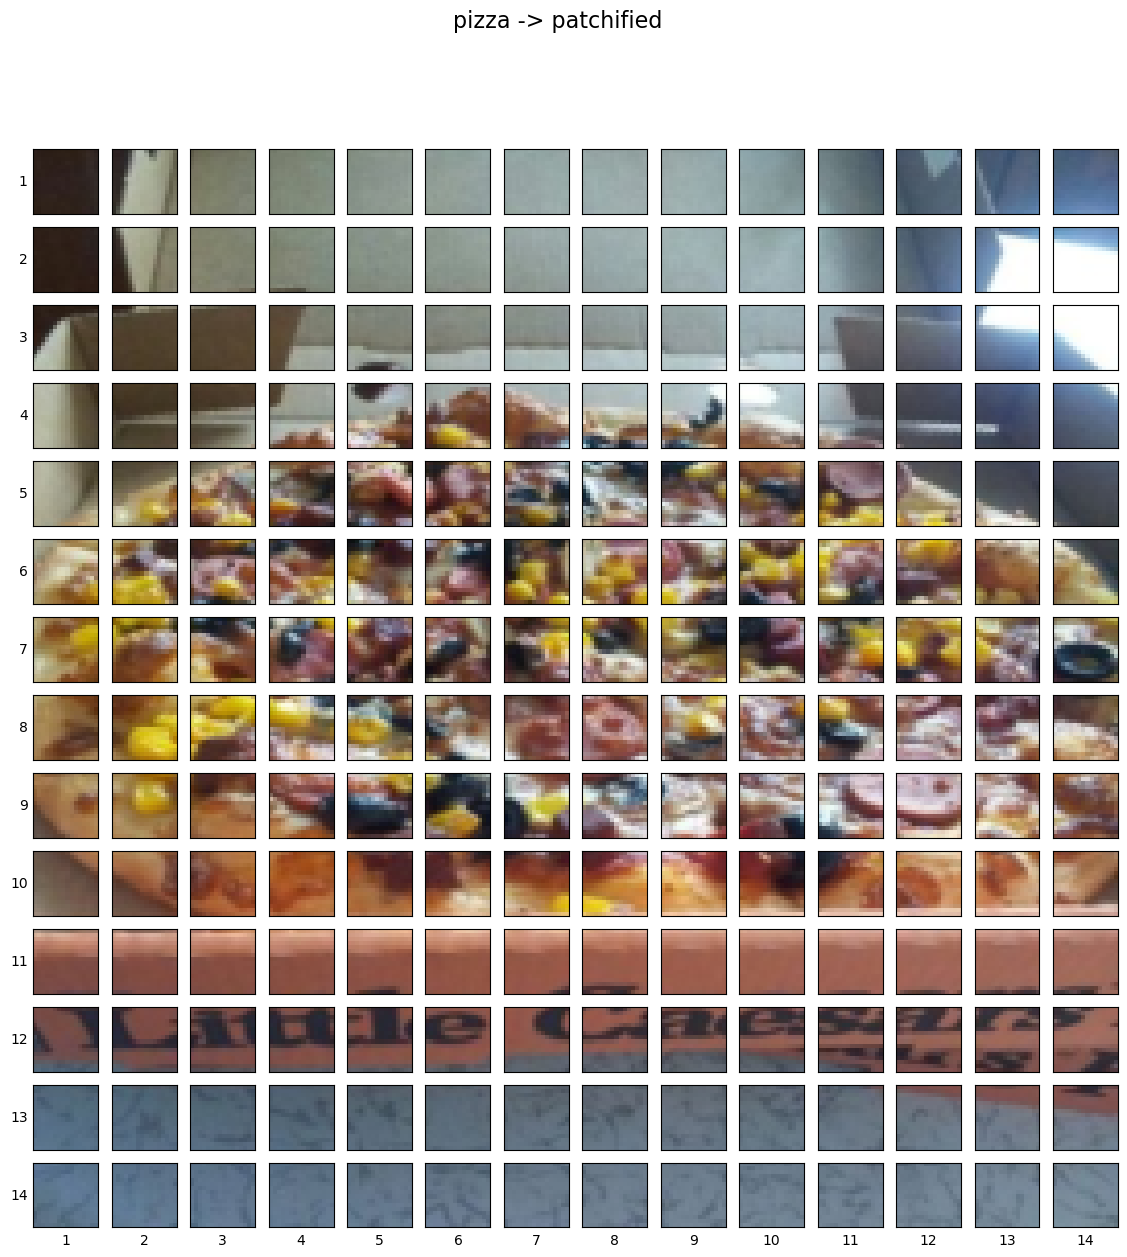

In [33]:
# setup hyperparameters and make sure img_size and patch_size are compatible 
img_size = 224
patch_size = 16
number_of_patches = img_size/patch_size 
assert img_size % patch_size == 0
print(f"Number of patches per row: {number_of_patches}\nNumber of patches per column: {number_of_patches}\nTotal patches: {number_of_patches*number_of_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots 
fig, axs = plt.subplots(nrows=img_size // patch_size, 
                        ncols=img_size//patch_size, 
                        figsize=(number_of_patches, number_of_patches), 
                        sharex=True, 
                        sharey=True)

# iterate through number of patches in the top row
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# set super title 
fig.suptitle(f"{class_names[label]} -> patchified", fontsize=16)
plt.show

### creating image patches with nn.Conv2d()

By setting the **kernel_size** and **stride** parameters of torch.nn.Conv2d() layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Line Projecttion" in the ViT paper) of each patch.

* Input (2D image): (224, 224, 3)
* Ouput (flattened 2D patches): (196, 768)

we can recreate these with: 
* torch.nn.Conv2d() for turning image into patches of CNN feature maps
* torch.nn.Flatten() for flattening the spatial dimensions of the feature map

In [34]:
from torch import nn 

# set the patch size
patch_size = 16 

# create the conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, 
                   out_channels=768,  # from table 1: hidden size D, this is the embedding size
                   kernel_size=patch_size, 
                   stride=patch_size, 
                   padding=0)

In [39]:
image_out_of_conv = conv2d(img.unsqueeze(dim=0)) # (C, H, W) -> (B, C, H, W)
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional featute maps from indices: [433, 331, 537, 514, 182]


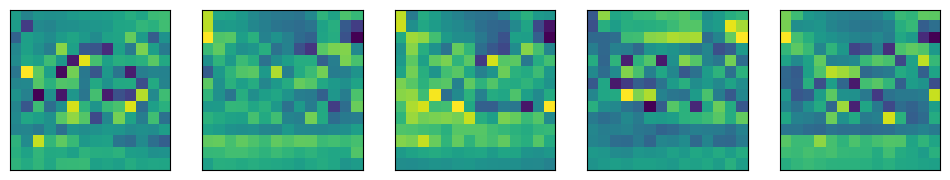

In [46]:
# plot random 5 convolutional feature maps 
import random 
random_indices = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional featute maps from indices: {random_indices}")

# create plot 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# plot random image feature maps 
for i, idx in enumerate(random_indices):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

**The important thing to note is that these features may change over time as the neural network learns.**

In [47]:
# get a single feature map in tensor form 
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-3.7587e-02, -1.0336e-01, -8.8466e-02, -9.5179e-02, -9.2791e-02,
           -9.1112e-02, -8.5747e-02, -8.7956e-02, -8.8103e-02, -8.2465e-02,
           -6.1686e-02, -7.1244e-02, -4.4647e-02, -8.6081e-02],
          [-2.4028e-02, -2.2654e-03, -7.0694e-02, -6.5826e-02, -8.4895e-02,
           -8.9384e-02, -7.5639e-02, -8.4642e-02, -8.7548e-02, -9.6946e-02,
           -7.3545e-02, -6.5993e-02, -9.9886e-02, -7.7331e-02],
          [-1.9028e-01, -4.2384e-02, -4.9248e-02, -5.3178e-02, -7.2331e-02,
           -4.5199e-02, -6.9359e-02, -4.7512e-02, -9.0605e-02, -9.1656e-02,
           -2.9648e-02, -4.9853e-02, -1.0879e-01, -6.6651e-02],
          [-1.4562e-02, -5.0020e-02, -4.4797e-02, -5.4594e-02, -2.7162e-01,
           -2.5145e-02, -6.4405e-02, -1.5928e-01, -2.1674e-01,  2.5178e-02,
            1.0397e-02, -2.6200e-02, -2.1541e-02, -1.0813e-01],
          [-8.3515e-03, -8.6821e-02, -1.8032e-01, -3.9685e-02,  2.5791e-03,
           -1.2462e-01, -1.0939e-01,  4.5165e-02, -1.5719e-0

The grad_fn output of the single_feature_map and the required_grad=True attribute means PyTorch is tracking the gradients of this featute map and it will be updated by gradient descent during training.

## Flattening the patch embedding with torch.nn.Flatten()

**Desired output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

In [48]:
# current tensor shapes 
print(f"{image_out_of_conv.shape} -> [batch, embedding dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch, embedding dim, feature_map_height, feature_map_width]



Well we've got the 768 part ( $(P^{2} \cdot C)$ ) but we still need the number of patches ($N$).

In [50]:
# create flatten layer to only flatten those dimensions: feature_map_height and feature_map_width
flatten = nn.Flatten(start_dim=2, end_dim=3)

1. Original image shape: torch.Size([3, 224, 224])
2. Image feature map shape: torch.Size([1, 768, 14, 14])
3. Flattened image feature map shape: torch.Size([1, 768, 196])


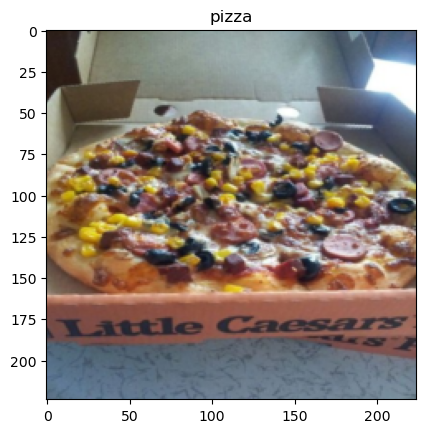

In [55]:
# puttin it all together

# 1. view single image
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
print(f"1. Original image shape: {img.shape}")

# 2. turn image into feature maps (patches)
image_out_of_conv = conv2d(img.unsqueeze(dim=0))
print(f"2. Image feature map shape: {image_out_of_conv.shape}")

# 3. flatten the feature maps 
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"3. Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

* Desired output (flattened 2D patches): (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$
* Current shape: (1, 768, 196)

In [57]:
# get flattened image patch embedding in the right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, number_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, number_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

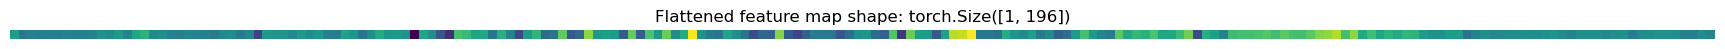

In [58]:
# get a single flattened feature map 
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

# plot the flattened feature map visually 
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

Note: The original Transformer architecture was designed to work with text. The Vision Transformer architecture (ViT) had the goal of using the original Transformer for images. This is why the input to the ViT architecture is processed in the way it is. We're essentially taking a 2D image and formatting it so it appears as a 1D sequence of text.

In [60]:
single_flattened_feature_map, single_flattened_feature_map.shape

(tensor([[-3.7587e-02, -1.0336e-01, -8.8466e-02, -9.5179e-02, -9.2791e-02,
          -9.1112e-02, -8.5747e-02, -8.7956e-02, -8.8103e-02, -8.2465e-02,
          -6.1686e-02, -7.1244e-02, -4.4647e-02, -8.6081e-02, -2.4028e-02,
          -2.2654e-03, -7.0694e-02, -6.5826e-02, -8.4895e-02, -8.9384e-02,
          -7.5639e-02, -8.4642e-02, -8.7548e-02, -9.6946e-02, -7.3545e-02,
          -6.5993e-02, -9.9886e-02, -7.7331e-02, -1.9028e-01, -4.2384e-02,
          -4.9248e-02, -5.3178e-02, -7.2331e-02, -4.5199e-02, -6.9359e-02,
          -4.7512e-02, -9.0605e-02, -9.1656e-02, -2.9648e-02, -4.9853e-02,
          -1.0879e-01, -6.6651e-02, -1.4562e-02, -5.0020e-02, -4.4797e-02,
          -5.4594e-02, -2.7162e-01, -2.5145e-02, -6.4405e-02, -1.5928e-01,
          -2.1674e-01,  2.5178e-02,  1.0397e-02, -2.6200e-02, -2.1541e-02,
          -1.0813e-01, -8.3515e-03, -8.6821e-02, -1.8032e-01, -3.9685e-02,
           2.5791e-03, -1.2462e-01, -1.0939e-01,  4.5165e-02, -1.5719e-01,
          -1.2829e-01,  7

Specifically we'll:

1. Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).
2. Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using nn.Conv2d() (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture (${N \times\left(P^{2} \cdot C\right)}$).

In [63]:
# 1. create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args: 
        in_channels (int): number of color channels for the input images
        patch_size (int): size of patches to convert input image into.
        embedding_dim (int): size of embedding to turn image into."""
    
    # 2. initialize the class with appropriate variables
    def __init__(self, in_channels: int=3, patch_size: int=16, embedding_dim: int=768):
        super().__init__()
        
        #3. create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)

        # 4. create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

        # 5. define forward method
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image sie must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # perform the forward pass
        x_patched = self.patcher(x) 
        x_flattened = self.flatten(x_patched)
        # 6. make the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [64]:
from utils import set_seeds

set_seeds()

# create an instance of patch embedding layer 
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# pass a single image through 
print(f"Input image shape: {img.unsqueeze(0).shape}")
patch_embedded_image = patchify(img.unsqueeze(0))
print(f"Output patch embeddig shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embeddig shape: torch.Size([1, 196, 768])


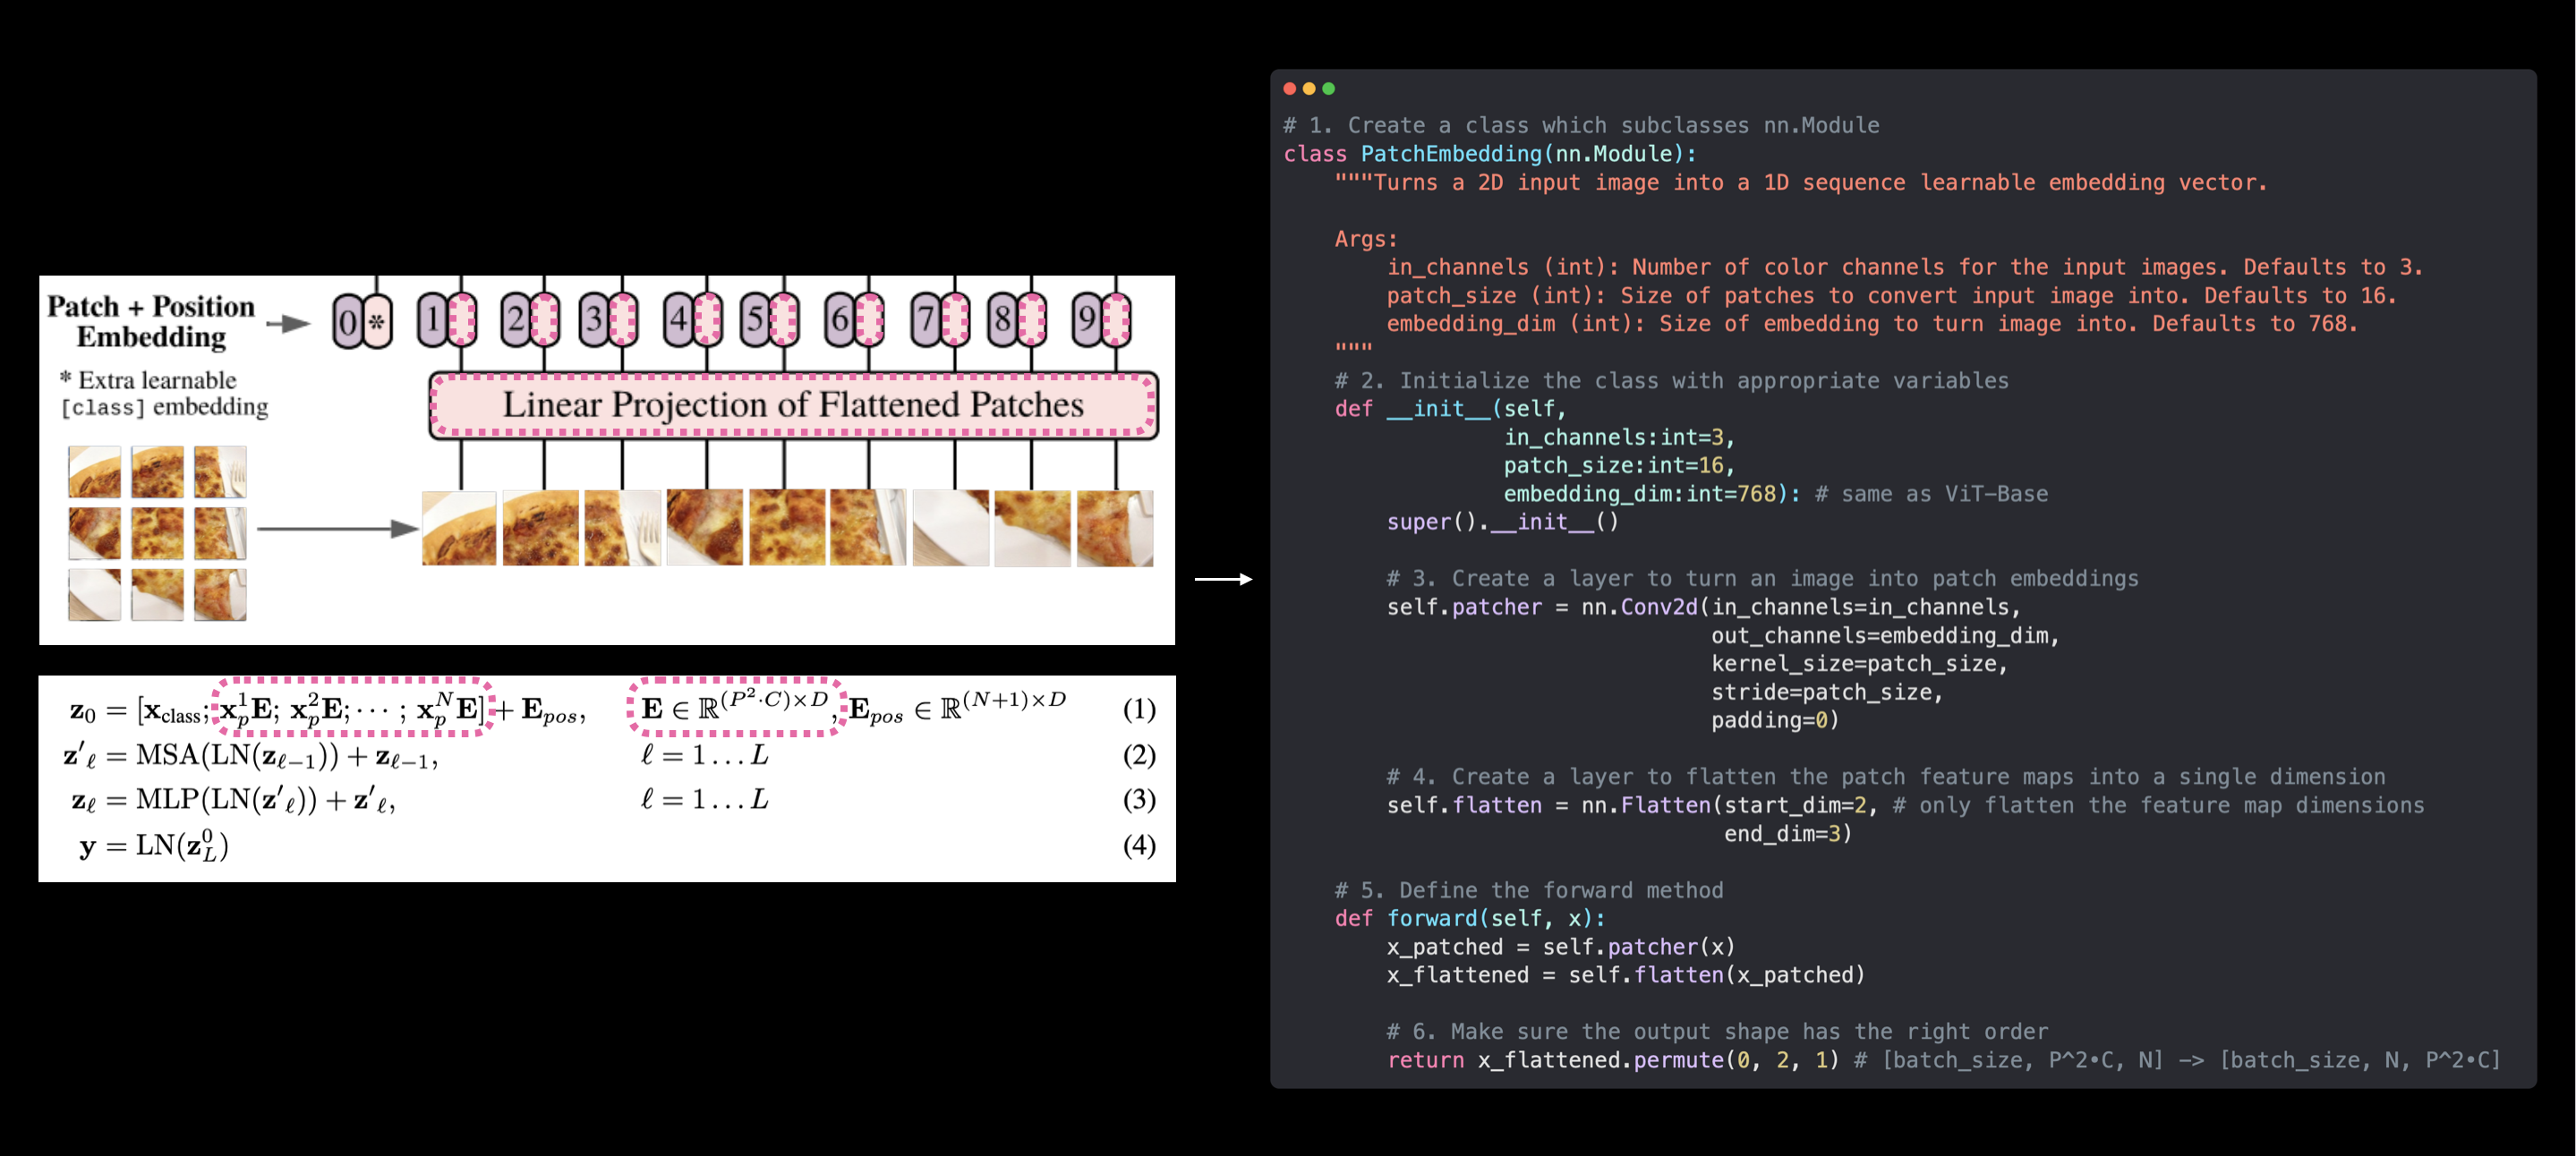

In [68]:
from torchinfo import summary 

# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## creating the class token embedding 

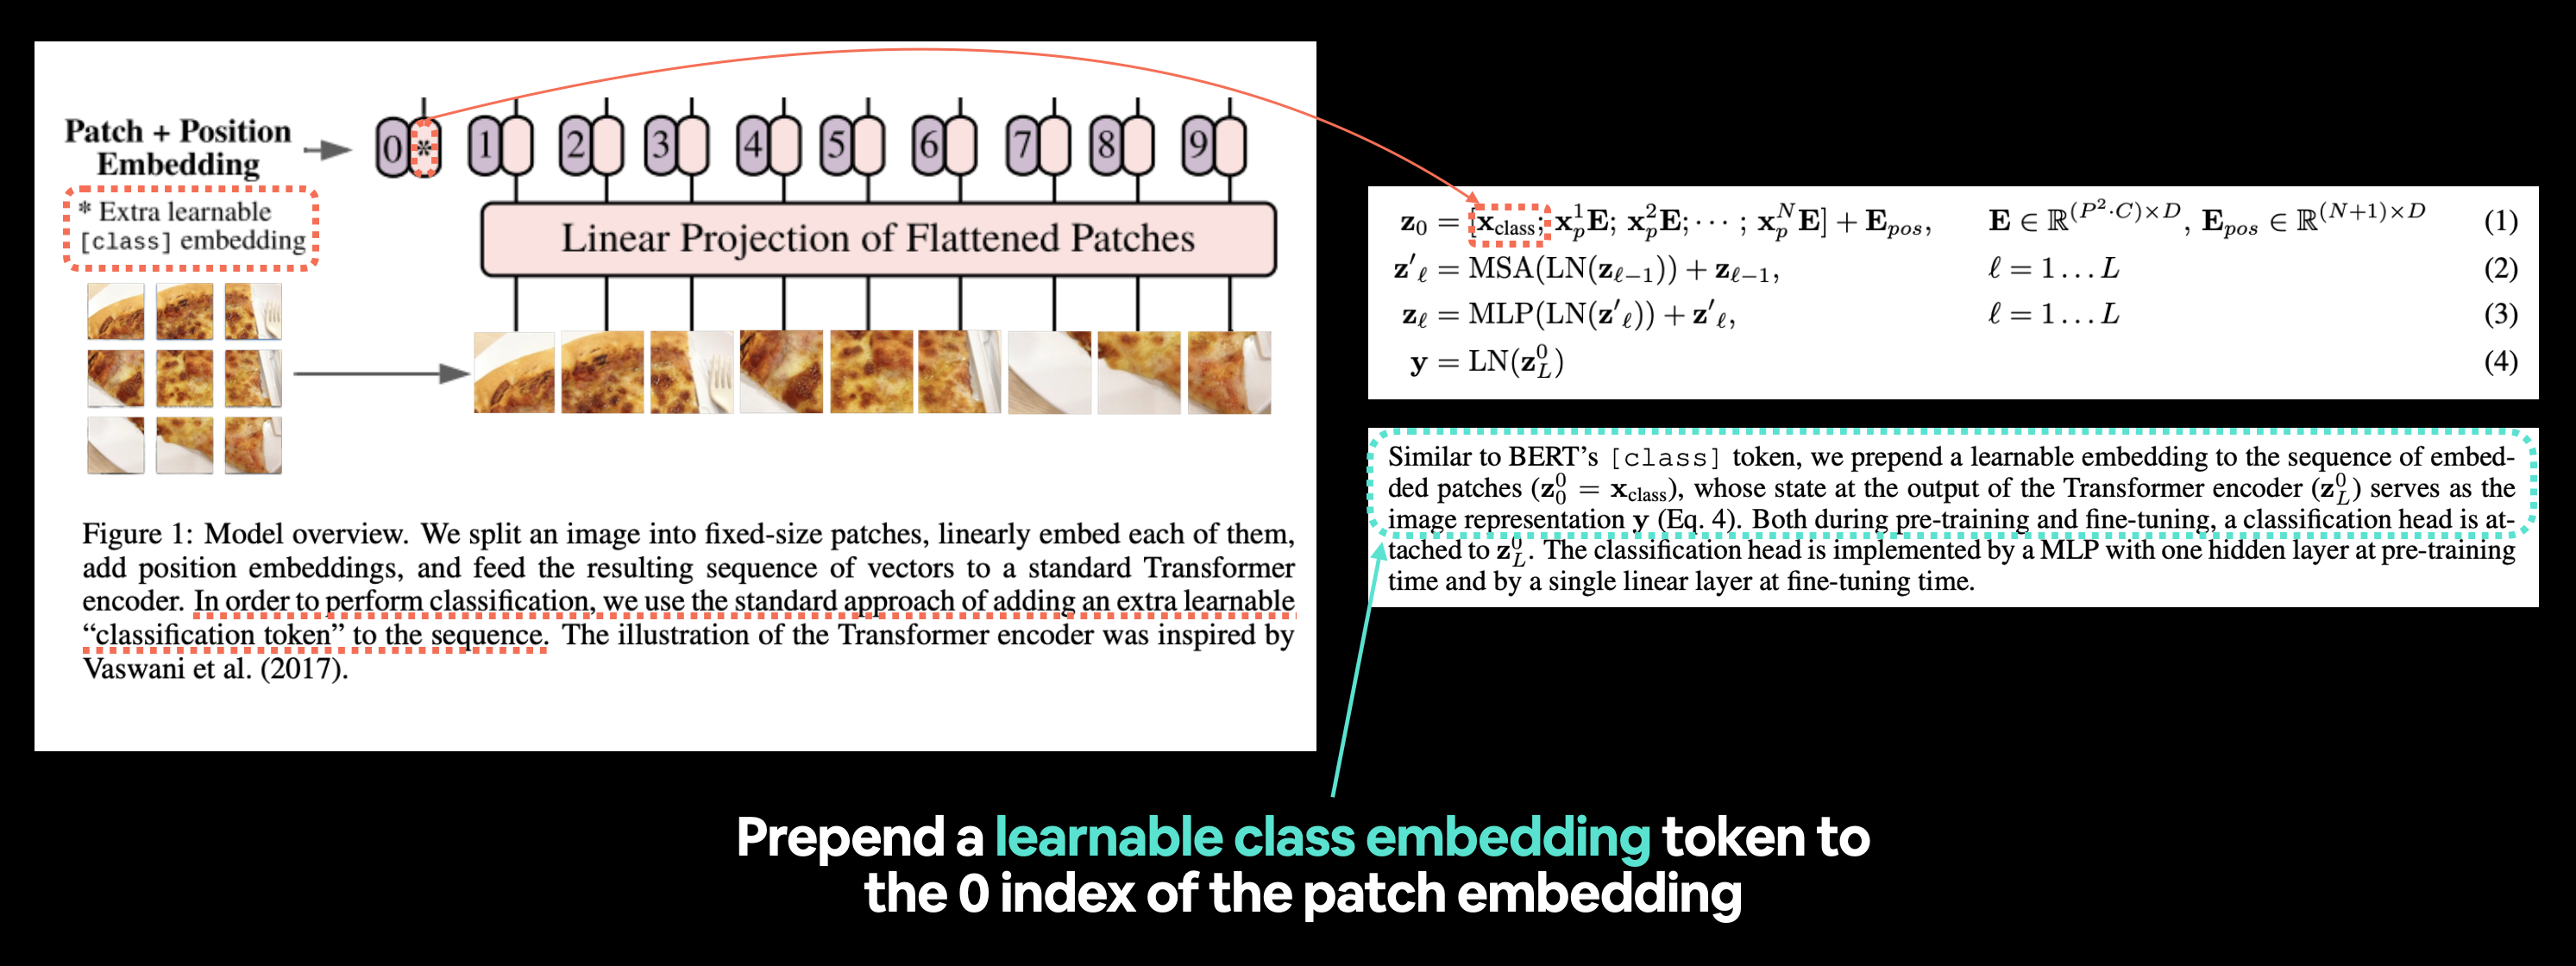